# MIDS UC Berkeley - Machine Learning at Scale
## DATSCIW261 ASSIGNMENT #9  

[James Gray](https://github.com/jamesgray007)   
jamesgray@ischool.berkeley.edu   
Time of Initial Submission: 08:15 PM US Central, Thursday, July 21, 2016  
Time of **Resubmission**:  
W261-1, Spring 2016  
Week 9 Homework

# Creation of Amazon EMR Cluster and S3 Bucket Info

This code will create an EMR cluster using the settings in .mrjob.conf file on my local MacBook Pro.

runners:
  emr:
    ec2_key_pair: w261   
    ec2_key_pair_file: ~/.aws/w261.pem   
    ssh_tunnel: true   
    aws_region: us-east-1   
    ec2_core_instance_type: m3.xlarge   
    ec2_master_instance_type: m3.xlarge   
    num_ec2_core_instances: 3  


### S3 Bucket = jamesgray-w261/

This is the bucket where the input data files are stored in addition to the MapReduce outputs

In [24]:
# create EMR Cluster
!mrjob create-cluster --max-hours-idle 1

Using configs in /Users/jamesgray/.mrjob.conf
Using s3://mrjob-5a4b4386e2160458/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/ld/9wpyxfw13t7_pdv_0b8958x40000gn/T/no_script.jamesgray.20160717.205210.939209
Copying local files to s3://mrjob-5a4b4386e2160458/tmp/no_script.jamesgray.20160717.205210.939209/files/...
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
j-GJVVP8IZB4EF


# HW 9.0: Short answer questions

**_What is PageRank and what is it used for in the context of web search?_**

PageRank is an algorithm used by Google Search to rank websites in their search engine results. PageRank was named after Larry Page, one of the founders of Google. PageRank is a way of measuring the importance of website pages. 
It measures the importance of web pages based on the probability that a user randomly surfing the webgraph lands on a given page. While it is not the only algorithm that is used in web search, it's one of the most famous and widely implemented.

According to Google:

PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.

**_What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?_**

Using the Markov Chain model, pages are represented as states and the webgraph is modeled as a transition matrix.  We need to modify the webgraph in the following manner:

* **Stochasticity** - The stochasticity adjustment is made in order to deal with dangling nodes. In order for a matrix to be stochastic, the rows must sum up to 1. Therefore, instead of using 1 to indicate a transition, a value 1/n is used where n represents the non-zero elements of a row. This adjustment now allows the random surfer to hyperlink to any page randomly after entering a dangling node. From this we now have a stochastic transition matrix H.

* **Primitivity** - The primivity adjustment is the random surfer getting bored with following the hyperlink structure and sometimes going to an entirely new web page and continuing from there. To achieve this, a damping factor (alpha) is introduced. This is a value between 0 and 1 and represents the probability of making a random jump (or "teleportation"). To achieve our final stochastic transition probability matrix P, we multiply H by (1-alpha) and add to it a teleportation matrix I(1/n) which is multiplied by alpha. Here, n represents the number of nodes in the graph.

from Lecture 9.6 - Random Walk as a Markov Chain

![markov](img/markov.png)



**_OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)_**


In [6]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# HW 9.1: MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7).Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1). 

[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called ‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]

As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A,0.033  
B,0.384  
C,0.343  
D,0.039  
E,0.081  
F,0.039  
G,0.016  
H,0.016  
I,0.016  
J,0.016  
K,0.016  

# HW 9.2 - MRJob Calculate Number of Nodes in Graph

In [7]:
%%writefile mrpagerankinit.py

from mrjob.job import MRJob
from mrjob.job import MRStep

class mrPageRankInit(MRJob):
            
    def mapper(self, _, line):
        """Emit keyless records (since we don't want to group our results)
        Values are (1,node_degree)"""
        line = line.strip('\n')
        data = line.split("\t")
        nid = data[0]
        N = eval(data[1])
        node_degree = len(N)
        for n in N.iteritems():
            yield _,(n[0],n[1])
        yield _,(nid,0)

        
    def reducer(self, _, line):
        """Aggregate node counts and degree counts"""
        nodes=set()
        edges=0
        for record in line:
            nodes.add(record[0])
            edges+=record[1]    
        yield None, (len(nodes),edges)
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    mrPageRankInit.run()

Overwriting mrpagerankinit.py


# HW 9.2 - PageRank MRJob

In [8]:
%%writefile mrpagerank.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class mrPageRank(MRJob):
    
    def configure_options(self):
        super(mrPageRank, self).configure_options()
        self.add_passthrough_option('--d', default=0.85, type=float,
                                    help='dampening factor')
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')
        self.add_passthrough_option('--iterations', default=2, type=int,
                                    help='how many iterations should we do?')

    
    def mapper_setup(self, nid, nodes_score):
        """
        Ensure that any nodes that are linked to but do not have any outlinks themselves
        are listed in the full list of nodes
        """
        nodes_score = nodes_score.strip('\n')
        nid, nodes = nodes_score.split('\t')
        #Emit original node
        yield nid, nodes
        nodes=eval(nodes)
        #Emit blank dicts for all linked nodes
        for n,w in nodes.iteritems():
            yield n,'{}'    
        
    def reducer_setup(self, nid, values):
        """
        Aggregate results from mapper evenly distribute starting probability mass
        """
        nodes={}
        for v in values:
            v=eval(v)
            nodes.update(v)
        score = 1/float(self.options.N)
        yield nid,str(nodes)+"|"+str(score)
    
    def mapper_distribute_weights(self, nid, nodes_score):
        """
        Main mapper maintains the graph in the stream, identifies dangling mass,
        and distributes each node's mass across its links
        """
        nodes_score = nodes_score.strip('\n')
        nodes,score=nodes_score.split('|')
        nodes=eval(nodes)
        score=float(score)
        # pass along graph structure
        yield nid, ('node', nodes)

        # pass mass associated with dangling nodes
        if len(nodes)==0:
            yield '*',('score',score)

        else:    
            #dispense mass from current node evenly across all linked nodes
            for n, w in nodes.iteritems():
                yield n, ('score', score*w/len(nodes))        
            
    def reducer_init_main(self):
        """Create a place to store running dangling mass total"""
        self.dangling_score=0
    
    def reducer_gather_weights(self, nid, values):
        """Aggregate dangling mass and node-by-node scores (not including dangling mass yet)"""
        nodes={}
        total_score = 0
        
        #Use order inversion to calculate total dangling mass
        if nid =='*':
            for typ, value in values:
                self.dangling_score+=value

        else:
            for typ, value in values:
                if typ == 'node':
                    nodes = value
                elif typ == 'score':
                    total_score += value

            yield nid, str(nodes)+"|"+str(total_score)
    
    def reducer_final_emit_dangling(self):
        """Emit total dangling mass for the graph"""
        yield '*',self.dangling_score
        
    def reducer_init_2(self):
        """Initialize dangling mass total on new reducer"""
        self.dangling_mass=0
        
    def reducer_distribute_dangling_weights(self, nid, nodes_score):
        """Compute final pagerank score for each node, based on 
        partial result from the previous step and the (now known)
        total dangling mass"""
        
        stripe=[v for v in nodes_score][0]
        if nid=='*':
            self.dangling_mass+=stripe
        else:
            nodes,partial_score=stripe.split("|")
            partial_score=eval(partial_score)
            
            N = self.options.N
            d = self.options.d
            
            new_mass=float(self.dangling_mass/self.options.N)
            score = (1-d)/float(N) + d*float(partial_score+new_mass)
            yield nid, str(nodes)+"|"+str(score)
            
    def steps(self):
        return (
                [MRStep(mapper = self.mapper_setup,
                       reducer=self.reducer_setup)] +
                
                # These two steps repeat over and over until we've completed
                # the desired number of iterations
                [MRStep(mapper = self.mapper_distribute_weights
                       ,reducer_init=self.reducer_init_main
                       ,reducer = self.reducer_gather_weights
                       ,reducer_final=self.reducer_final_emit_dangling
                       )
                ,
                MRStep(
                    reducer_init=self.reducer_init_2,
                    reducer = self.reducer_distribute_dangling_weights
                       )
                ]*self.options.iterations
        )
    
if __name__ == '__main__':
    mrPageRank.run()

Overwriting mrpagerank.py


# HW 9.2 - PageRank Driver

In [9]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankinit import mrPageRankInit
from __future__ import division

num_iterations=40
nodes=0 #initialize number of nodes

input_dir_prefix='PageRank-test'
input_directory=input_dir_prefix+'.txt'
output_directory=input_dir_prefix+'Output.txt'

mr_job = mrPageRankInit(args=[input_directory,'--no-strict-protocols'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
print "Total Nodes = {}".format(nodes)


def run_jobs(d,output_directory):
#LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job2 = mrPageRank(args=[input_directory,
                              '--no-strict-protocols',
                              '--d',d,
                              '--N',str(nodes),
                              '--iterations',str(num_iterations)])


    total_score=0 #Keep track of our total probability mass to make sure it sums to 1
    with mr_job2.make_runner() as runner2: 
        runner2.run()
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner2.stream_output():
                print line.strip()
                nid,stripe =  mr_job.parse_output_line(line)
                _,score=stripe.split("|")
                total_score+=eval(score)
                output=str(nid)+'\t'+str(stripe)+'\n'
                f.write(output)
        print "TOTAL SCORE: "+str(total_score)
        print ""

    print "ALL DONE"

run_jobs(0.85,output_directory)

Total Nodes = 11
"A"	"{}|0.0276459347142"
"B"	"{'C': 1}|0.324023707908"
"C"	"{'B': 1}|0.289346732644"
"D"	"{'A': 1, 'B': 1}|0.0329636966539"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0682141165326"
"F"	"{'B': 1, 'E': 1}|0.0329636966539"
"G"	"{'B': 1, 'E': 1}|0.0136363636364"
"H"	"{'B': 1, 'E': 1}|0.0136363636364"
"I"	"{'B': 1, 'E': 1}|0.0136363636364"
"J"	"{'E': 1}|0.0136363636364"
"K"	"{'E': 1}|0.0136363636364"
TOTAL SCORE: 0.843339703289

ALL DONE


# HW 9.2: Exploring PageRank teleportation and network plots

In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,so that each nodes radius is proportional to its PageRank score. In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

### Code Notes:

Here we will execute a loop to calculate PageRank using different damping factors.

In [10]:
# Here we will calculate pagerank for different alphas by calling the PageRank Driver function.

factors=[0,0.25,0.5,0.75, 0.85, 1]
for d in factors:
    print "running job for alpha="+str(d)
    output_directory='92d'+str(d)+'.txt'
    run_jobs(d,output_directory)

running job for alpha=0
"A"	"{}|0.0909090909091"
"B"	"{'C': 1}|0.0909090909091"
"C"	"{'B': 1}|0.0909090909091"
"D"	"{'A': 1, 'B': 1}|0.0909090909091"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0909090909091"
"F"	"{'B': 1, 'E': 1}|0.0909090909091"
"G"	"{'B': 1, 'E': 1}|0.0909090909091"
"H"	"{'B': 1, 'E': 1}|0.0909090909091"
"I"	"{'B': 1, 'E': 1}|0.0909090909091"
"J"	"{'E': 1}|0.0909090909091"
"K"	"{'E': 1}|0.0909090909091"
TOTAL SCORE: 1.0

ALL DONE
running job for alpha=0.25
"A"	"{}|0.0781399521531"
"B"	"{'C': 1}|0.151674641148"
"C"	"{'B': 1}|0.106100478469"
"D"	"{'A': 1, 'B': 1}|0.0796650717703"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.137799043062"
"F"	"{'B': 1, 'E': 1}|0.0796650717703"
"G"	"{'B': 1, 'E': 1}|0.0681818181818"
"H"	"{'B': 1, 'E': 1}|0.0681818181818"
"I"	"{'B': 1, 'E': 1}|0.0681818181818"
"J"	"{'E': 1}|0.0681818181818"
"K"	"{'E': 1}|0.0681818181818"
TOTAL SCORE: 0.973953349282

ALL DONE
running job for alpha=0.5
"A"	"{}|0.0627470355731"
"B"	"{'C': 1}|0.214097496707"
"C"	"{'B': 1}|0.15250329

## HW9.2 - Plot Network Using Networkx Python Package

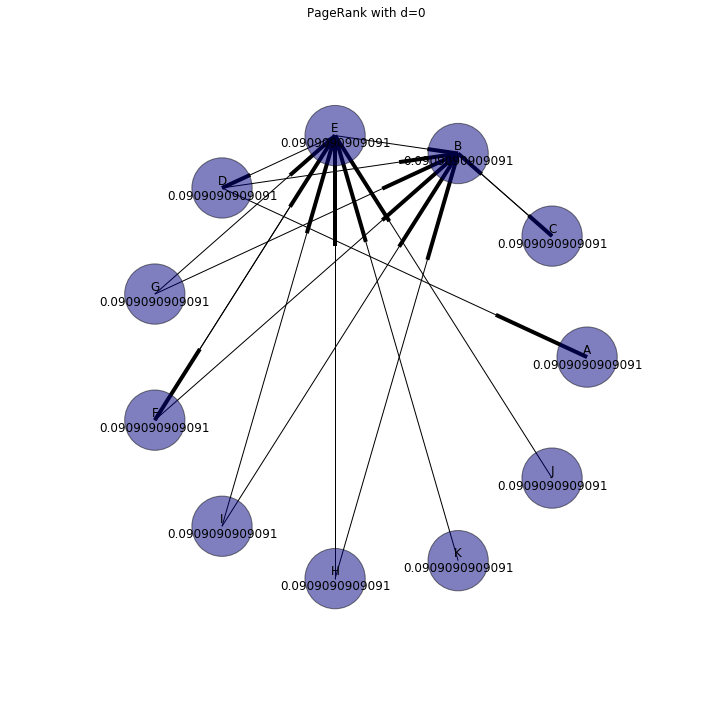

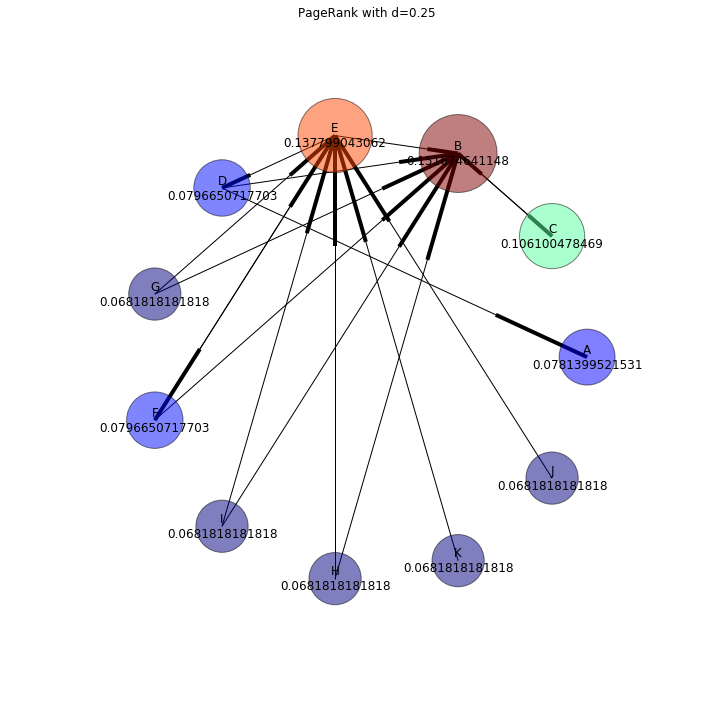

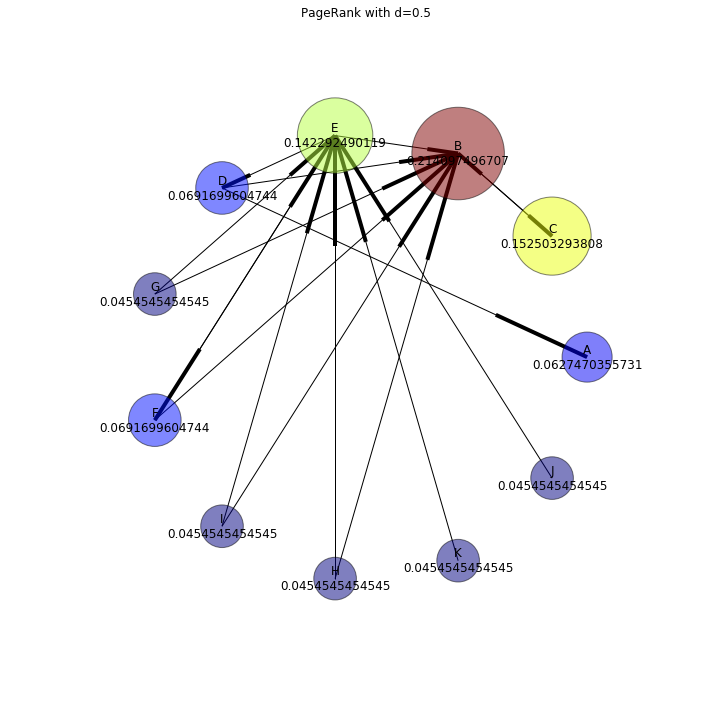

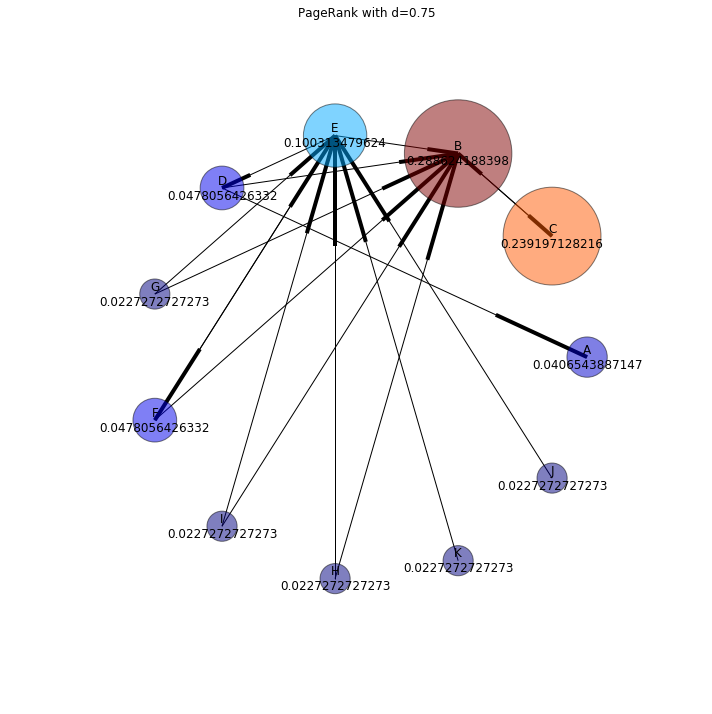

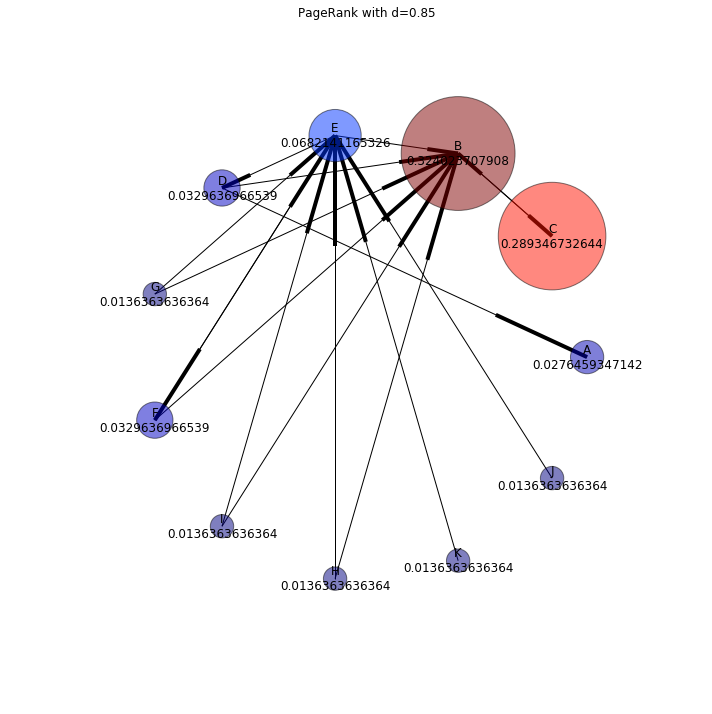

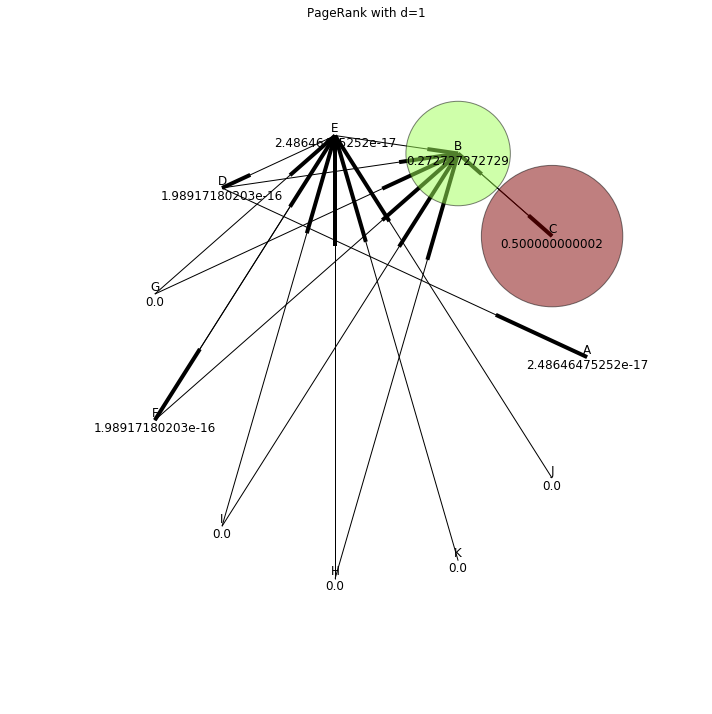

In [11]:
%matplotlib inline
import networkx as nx
import ast
from matplotlib import pyplot as plt

# Draw graphs
def draw(edges, scores, d):
    plt.figure(figsize=(10, 10))

    # initialize directed graph
    DG = nx.DiGraph()

    # add edges
    for edge in edges:
        DG.add_edge(edge[0], edge[1])    
    
    node_size = [scores[n]*40000 for n in DG.nodes()]

    graph_pos = nx.circular_layout(DG)

    # set labels
    labels = {}    
    for node in DG.nodes():
        labels[node] = '{}\n{}'.format(node, scores[node])

    # draw graph
    nx.draw_networkx_nodes(DG, graph_pos, node_size = node_size, node_color=node_size, alpha = 0.5)
    nx.draw_networkx_edges(DG, graph_pos, edge_color = 'black', arrows = True)
    nx.draw_networkx_labels(DG, graph_pos, labels=labels, font_size = 12)

    # show graph
    plt.title("PageRank with d={}".format(d))
    plt.axis('off')
    plt.tight_layout()
    plt.show()    

# Take filename, damping factor as input to produce plots by drawing graphs
def plot(f, d):
    edges = []
    scores = {}
    
    for line in open(f).read().strip().split('\n'):
        nid, nodes_score = line.split('\t') # Parse the line into the main node id and the nodes_score string
        
        nid = nid.replace('"', '') # Remove double quotes from node name
        
        nodes, score = map(ast.literal_eval, nodes_score.strip('"').split('|')) # Parse nodes_score string into nodes and score
        
        edges.extend([(nid, n) for n in nodes.keys()]) # For each node in nodes, add an edge from main node id
        scores[nid] = score # Set the score for the main node id
        
    draw(edges, scores, d) # Send our edges and scores and damping factor to the final draw function

D = [0, 0.25, 0.5, 0.75, 0.85, 1]
    
for d in D:
    f = '92d{}.txt'.format(d)
    plot(f, d)

# HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

Run your PageRank implementation on the Wikipedia dataset for 5 iterations,and display the top 100 ranked nodes (with alpha = 0.85).

1. Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). 
2. Have the top 100 ranked pages changed? Comment on your findings. 
3. Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. 
4. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


## HW9.3 - Run First Pass Across the Network

In [12]:
%%writefile mrpagerankfirstpass.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class mrPageRankFirstPass(MRJob):
    
    def configure_options(self):
        super(mrPageRankFirstPass, self).configure_options()
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')

    def mapper_setup(self, nid, nodes_score):
        nodes_score = nodes_score.strip('\n')
        nid, nodes = nodes_score.split('\t')
        yield str(nid), nodes
        nodes=eval(nodes)
        for n,w in nodes.iteritems():
            yield str(n),'{}'    
        
    def reducer_setup(self, nid, values):
        nodes={}
        for v in values:
            v=eval(v)
            nodes.update(v)
        score = 1/float(self.options.N)
        yield str(nid),str(nodes)+"|"+str(score)
    
            
    def steps(self):
        return (
                #Init step - add dangling nodes as separate stripes and distributes
                #starting mass evenly
                [MRStep(mapper = self.mapper_setup,
                       reducer=self.reducer_setup)] )
    
if __name__ == '__main__':
    mrPageRankFirstPass.run()

Writing mrpagerankfirstpass.py


## HW 9.3 - PageRank MRJob

In [13]:
%%writefile mrpagerank.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class mrPageRank(MRJob):
    
    def configure_options(self):
        super(mrPageRank, self).configure_options()
        self.add_passthrough_option('--d', default=0.85, type=float,
                                    help='dampening factor')
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')
        self.add_passthrough_option('--dangling', default=0, type=float,
                                    help='What dangling mass do we have from the last iteration?')
    
    def mapper_distribute_weights(self, _, line):
        """Split each node's mass between linked nodes"""
        line=line.strip('\n')
        nid,nodes_score=line.split('\t')
        #nodes_score=eval(nodes_score) #Comment this out when running locally
        nodes,score=nodes_score.split('|')
        #nid=eval(nid)#Comment this out when running locally
        nodes=eval(nodes)
        score=float(score)
        # pass along graph structure
        yield str(nid), ('node', nodes)

        #dispense mass from current node evenly across all linked nodes
        for n, w in nodes.iteritems():
            yield str(n), ('score', score*w/len(nodes))        
    
    def reducer_gather_weights(self, nid, values):
        """Aggregate new mass associated with each node"""
        nodes={}
        partial_score = 0

        for typ, value in values:
            if typ == 'node':
                nodes = value
            elif typ == 'score':
                partial_score += value

        N = self.options.N
        d = self.options.d
        mass=self.options.dangling
        new_mass=float(mass/N)

        score = (1-d)/float(N) + d*float(partial_score+new_mass)
    
        yield str(nid), str(nodes)+"|"+str(score)
    
            
    def steps(self):
        return (
                #Main step - redistribute and gather weights
                [MRStep(mapper = self.mapper_distribute_weights
                       ,reducer = self.reducer_gather_weights
                       )
                ]
        )
    
if __name__ == '__main__':
    mrPageRank.run()

Overwriting mrpagerank.py


## HW 9.3 - Dangling Nodes

In [14]:
%%writefile mrpageranksumweight.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep

class mrPageRankSumWeight(MRJob):

    def mapper(self, _, line):
        """Scan for dangling nodes and emit associated mass"""
        line=line.strip('\n')
        nid,nodes_score=line.split('\t')
        #nodes_score=eval(nodes_score) #comment this out when running locally
        nodes,score=nodes_score.split('|')
        nodes=eval(nodes)
        score=float(score)

        # pass mass associated with dangling nodes
        if len(nodes)==0:
            yield _,score
     
    
    def reducer(self, nid, values):
        """
        Aggregate total dangling mass
        The final sum is calculated in the driver
        to enable this to work on multiple reducers
        """
        mass = sum([i for i in values])
        
        #Emit total dangling mass
        yield None, str(mass)
    
            
    def steps(self):
        return (
                #Main step - redistribute and gather weights
                [MRStep(mapper = self.mapper
                       ,reducer = self.reducer
                       )
                ]
        )
    
if __name__ == '__main__':
    mrPageRankSumWeight.run()

Writing mrpageranksumweight.py


## HW 9.3 - MRJob Driver (Local Test)

In [25]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankfirstpass import mrPageRankFirstPass
from mrpageranksumweight import mrPageRankSumWeight
from __future__ import division

num_iterations=50
input_dir_prefix='PageRank-test'
nodes=11 #We already know this, but we could run our init job to calculate it on the fly
dangling_mass=0
d=0.85
current_iteration=1
input_directory=input_dir_prefix+'.txt'
output_directory=input_dir_prefix+'Output{0}.txt'.format(str(current_iteration))

mr_job = mrPageRankFirstPass(args=[input_directory,'--no-strict-protocols','--N',str(nodes)])

#First job only runs once, expands graph, and evenly distributes starting mass
total_score=0
with mr_job.make_runner() as runner: 
    runner.run()
    #Stream output locally
    with open(output_directory, 'w+') as f:
        for line in runner.stream_output():
            nid,stripe =  mr_job.parse_output_line(line)
            _,score=stripe.split("|")
            total_score+=eval(score)
            output=str(nid)+'\t'+str(stripe)+'\n'
            f.write(output)

dangling_mass=0
mr_job3 = mrPageRankSumWeight(args=[output_directory,'--no-strict-protocols'])

with mr_job3.make_runner() as runner3: 
    runner3.run()
    for line in runner3.stream_output():
        _,partial_mass =  mr_job.parse_output_line(line)
        dangling_mass+=eval(partial_mass)

#Start main job loop        
current_iteration+=1
while current_iteration<=num_iterations:
    input_directory=input_dir_prefix+'Output{0}.txt'.format(str(current_iteration-1))
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(current_iteration))
    
    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    #Second job does the main pagerank calculation
    mr_job2 = mrPageRank(args=[input_directory,
                              '--no-strict-protocols',
                              '--d',d,
                              '--N',str(nodes),
                              '--dangling',str(dangling_mass)])


    total_score=0
    with mr_job2.make_runner() as runner2: 
        runner2.run()
        #Stream output locally
        with open(output_directory, 'w+') as f:
            if current_iteration in [2,3,10]:
                print "Iteration {0}".format(str(current_iteration))
            for line in runner2.stream_output():
                if current_iteration in [2,3,10]:
                    #pass
                    print line.strip()
                nid,stripe =  mr_job.parse_output_line(line)
                _,score=stripe.split("|")
                total_score+=eval(score)
                output=str(nid)+'\t'+str(stripe)+'\n'
                f.write(output)
            if current_iteration in [2,3,10]:
                print ""
    
    #Third job aggregates the dangling mass
    dangling_mass=0
    mr_job3 = mrPageRankSumWeight(args=[output_directory,
                          '--no-strict-protocols'])
    
    with mr_job3.make_runner() as runner3: 
        runner3.run()
        for line in runner3.stream_output():
            _,partial_mass =  mr_job.parse_output_line(line)
            dangling_mass+=eval(partial_mass)
            
    current_iteration+=1

print "job completed"


Iteration 2
"A"	"{}|0.0592975206612"
"B"	"{'C': 1}|0.316873278237"
"C"	"{'B': 1}|0.0979338842975"
"D"	"{'A': 1, 'B': 1}|0.0464187327824"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.329752066116"
"F"	"{'B': 1, 'E': 1}|0.0464187327824"
"G"	"{'B': 1, 'E': 1}|0.0206611570248"
"H"	"{'B': 1, 'E': 1}|0.0206611570248"
"I"	"{'B': 1, 'E': 1}|0.0206611570248"
"J"	"{'E': 1}|0.0206611570248"
"K"	"{'E': 1}|0.0206611570248"

Iteration 3
"A"	"{}|0.0379464062109"
"B"	"{'C': 1}|0.260690896569"
"C"	"{'B': 1}|0.28756073128"
"D"	"{'A': 1, 'B': 1}|0.111648196845"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0994133483597"
"F"	"{'B': 1, 'E': 1}|0.111648196845"
"G"	"{'B': 1, 'E': 1}|0.0182184447784"
"H"	"{'B': 1, 'E': 1}|0.0182184447784"
"I"	"{'B': 1, 'E': 1}|0.0182184447784"
"J"	"{'E': 1}|0.0182184447784"
"K"	"{'E': 1}|0.0182184447784"

Iteration 10
"A"	"{}|0.0332687068063"
"B"	"{'C': 1}|0.407854824347"
"C"	"{'B': 1}|0.317343174668"
"D"	"{'A': 1, 'B': 1}|0.0393481751578"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0818030685032"
"F"	"{'B': 1, '

## HW 9.3 - Unit Test on Amazon EMR

NOTE -> I was not able to fully get this unit test running on Amazon EMR for some reason.

In [23]:
## HW9.3 - Test dataset, running in EMR
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankfirstpass import mrPageRankFirstPass
from mrpageranksumweight import mrPageRankSumWeight
from __future__ import division

num_iterations=3
input_dir_prefix='PageRank-test'
nodes=11 #We already know this, but we could run our init job to calculate it on the fly if we wanted to
dangling_mass=0
d=0.85
current_iteration=1

input_dir_prefix='PageRank-test'
input_directory='s3://jamesgray-w261/'+input_dir_prefix+'.txt'
output_directory='s3://jamesgray-w261/'+input_dir_prefix+'Output{0}'.format(str(current_iteration))
cluster='j-33HX7F7EC8EA8'

mr_job = mrPageRankFirstPass(args=[
        '-r','emr',
        input_directory,
        '--no-strict-protocols',
        '--output-dir',output_directory,
        '--emr-job-flow-id', cluster,
        '--no-output',
        '--N',str(nodes)
        ])

#First job only runs once, expands graph, and evenly distributes starting mass
with mr_job.make_runner() as runner: 
    runner.run()

dangling_mass=0
mr_job3 = mrPageRankSumWeight(args=[
        '-r','emr',
        output_directory+'/',
        '--no-strict-protocols',
        '--no-output',
        '--emr-job-flow-id', cluster])

with mr_job3.make_runner() as runner3: 
    runner3.run()
    for line in runner3.stream_output():
        _,partial_mass =  mr_job.parse_output_line(line)
        dangling_mass+=eval(partial_mass)

#Start main job loop
current_iteration+=1
while current_iteration<=num_iterations:
    print current_iteration
    input_directory='s3://jamesgray-w261/'+input_dir_prefix+'Output{0}/'.format(str(current_iteration-1))
    output_directory='s3://jamesgray-w261/'+input_dir_prefix+'Output{0}'.format(str(current_iteration))
    
    #Second job does the main pagerank calculation
    mr_job2 = mrPageRank(args=['-r','emr',
                              input_directory,
                              '--no-strict-protocols',
                              '--d',str(d),
                              '--N',str(nodes),
                              '--dangling',str(dangling_mass),
                              '--output-dir',output_directory,
                              '--emr-job-flow-id', cluster,
                              '--no-output'])


    with mr_job2.make_runner() as runner2: 
        runner2.run()
    
    #Third job aggregates the dangling mass
    dangling_mass=0
    mr_job3 = mrPageRankSumWeight(args=[
        '-r','emr',
        output_directory+'/',
        '--no-strict-protocols',
        '--no-output',
        '--emr-job-flow-id', cluster])
    
    with mr_job3.make_runner() as runner3: 
        runner3.run()
        for line in runner3.stream_output():
            _,partial_mass =  mr_job3.parse_output_line(line)
            dangling_mass+=eval(partial_mass)
            
    current_iteration+=1

print "job completed"


StepFailedException: Step 1 of 1 failed

## HW 9.3 - Run Entire Wikipedia Data on Amazon EMR

In [ ]:
## HW9.3 - Full dataset, running in EMR
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankfirstpass import mrPageRankFirstPass
from mrpageranksumweight import mrPageRankSumWeight
from __future__ import division

num_iterations=10
input_dir_prefix='all-pages-indexed-out'
nodes=5781290 #We already know this, but we could run our init job to calculate it on the fly if we needed to
dangling_mass=0
d=0.85
current_iteration=1

input_directory='s3://jamesgray-w261/'+input_dir_prefix+'.txt'
output_directory='s3://jamesgray-w261/'+input_dir_prefix+'Output{0}'.format(str(current_iteration))
cluster='j-33HX7F7EC8EA8'

mr_job = mrPageRankFirstPass(args=[
        '-r','emr',
        input_directory,
        '--no-strict-protocols',
        '--output-dir',output_directory,
        '--emr-job-flow-id', cluster,
        '--no-output',
        '--N',str(nodes)
        ])

#First job only runs once, expands graph, and evenly distributes starting mass
with mr_job.make_runner() as runner: 
    runner.run()

mr_job3 = mrPageRankSumWeight(args=[
        '-r','emr',
        output_directory+'/',
        '--no-strict-protocols',
        '--no-output',
        '--emr-job-flow-id', cluster])

with mr_job3.make_runner() as runner3: 
    runner3.run()
    for line in runner3.stream_output():
        _,partial_mass =  mr_job.parse_output_line(line)
        dangling_mass+=eval(partial_mass)

current_iteration+=1
while current_iteration<=num_iterations:
    print current_iteration
    input_directory='s3://jamesgray-w261/'+input_dir_prefix+'Output{0}/'.format(str(current_iteration-1))
    output_directory='s3://jamesgray-w261/'+input_dir_prefix+'Output{0}'.format(str(current_iteration))
    
    #Second job does the main pagerank calculation
    mr_job2 = mrPageRank(args=['-r','emr',
                              input_directory,
                              '--no-strict-protocols',
                              '--d',str(d),
                              '--N',str(nodes),
                              '--dangling',str(dangling_mass),
                              '--output-dir',output_directory,
                              '--emr-job-flow-id', cluster,
                              '--no-output'])


    with mr_job2.make_runner() as runner2: 
        runner2.run()
    
    #Third job aggregates the dangling mass
    dangling_mass=0
    mr_job3 = mrPageRankSumWeight(args=[
        '-r','emr',
        output_directory+'/',
        '--no-strict-protocols',
        '--no-output',
        '--emr-job-flow-id', cluster])
    
    with mr_job3.make_runner() as runner3: 
        runner3.run()
        for line in runner3.stream_output():
            _,partial_mass =  mr_job3.parse_output_line(line)
            dangling_mass+=eval(partial_mass)
            
    current_iteration+=1

print "job completed"


# HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

**Run topic specific PageRank on the following randomly generated network of 100 nodes:**

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.




# HW 9.5: (OPTIONAL) Applying topic-specific PageRank to Wikipedia

Here you will apply your topic-specific PageRank implementation to Wikipedia, defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10, so that there are 
10 topics. Once again, print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result.Assume a teleportation factor of 0.15 in all your analyses. Run for 10 iterations.

Plot the pagerank values for the top 100 pages resulting from the 5 iterations run in HW9.3. Then plot the pagerank values for the same 100 pages that result from the topic specific pagerank after 10 iterations run. Comment on your findings.   


# HW 9.6: (OPTIONAL) TextRank

What is TextRank. Describe the main steps in the algorithm. Why does TextRank work?
Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):

"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." 

The extracted keywords should in the following set:

linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds